# Visualisation of the simulation
This notebook provides graphical representations of the simulated tumour, the glands which are selected for "sequencing", and the methylation array histograms and correlation plots. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
# Define relative paths to output files
outputs_path = '/Users/vesheljinn/Documents/github_repos/methdemon/src/test_out/'
methylation_file = 'output_methylation_arrays.dat'
demes_file = 'output_deme_methylation.dat'

In [3]:
# If you haven't already, run the following command to generate the data:
# !../resources/methdemon/bin/methdemon ../data/synthetic_tumour_1 config.dat

In [4]:
# Read in the output files
methylation = pd.read_csv(outputs_path + methylation_file, sep='\t')
demes = pd.read_csv(outputs_path + demes_file, sep='\t')
carrying_capacity = demes.Population.max() - 1
filled_demes = demes[demes['Population'] == carrying_capacity]

In [5]:
filled_demes.shape

(662, 5)

In [6]:
# Separate the demes methylation array strings into lists of floats
deme_arrays = filled_demes.AverageArray.apply(lambda x: [float(i) for i in x.split()])

Text(0.5, 1.0, 'Deme 188 methylation array')

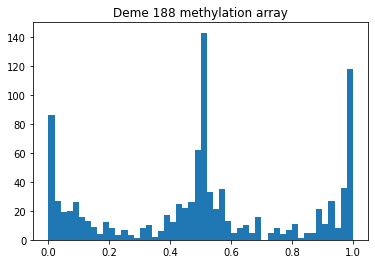

In [7]:
# Plot a randomly selected deme's methylation array
# Randomly select deme to plot
deme = np.random.randint(0, len(deme_arrays))
# Plot the deme's methylation histogram
plt.hist(deme_arrays.iloc[deme], bins=50)
plt.title('Deme ' + str(deme) + ' methylation array')

In [8]:
# Set origin coordinates in the middle of the tumour
xorigin = filled_demes.X.median()
yorigin = filled_demes.Y.median()

In [9]:
# Separate tumour into left and right sides
left_glands = filled_demes[filled_demes['X'] < xorigin].sort_values(by='Y')
right_glands = filled_demes[filled_demes['X'] >= yorigin].sort_values(by='Y')

In [10]:
def select_demes(demes):
    # Determine the edge X values
    min_x = demes['X'].min()
    max_x = demes['X'].max()

    # Filter demes based on proximity to the edge X values
    left_demes = demes[demes['X'] <= min_x + 10]
    right_demes = demes[demes['X'] >= max_x - 10]

    # Sort these demes based on their population in descending order
    left_demes_sorted = left_demes.sort_values(by='Population', ascending=False)
    right_demes_sorted = right_demes.sort_values(by='Population', ascending=False)

    # Select the top 4 demes from each side
    left_selection = left_demes_sorted.head(4)
    right_selection = right_demes_sorted.head(4)

    return left_selection, right_selection

In [11]:
left_selection, right_selection = select_demes(demes)

In [12]:
left_arrays = left_selection.AverageArray.apply(lambda x: [float(i) for i in x.split()])
right_arrays = right_selection.AverageArray.apply(lambda x: [float(i) for i in x.split()])

In [13]:
def plot_demes(demes, left_selection, right_selection):
    min_population = demes['Population'].min()
    max_population = demes['Population'].max()

    # Plot all demes in greyscale based on population
    scatter = plt.scatter(demes['X'], demes['Y'], c=demes['Population'], cmap='gray_r', s=100, label='All Demes', vmin=min_population, vmax=max_population)
    
    # Highlight the selected demes
    plt.scatter(left_selection['X'], left_selection['Y'], color='blue', edgecolors='white', s=150, label='Left Selection')
    plt.scatter(right_selection['X'], right_selection['Y'], color='red', edgecolors='white', s=150, label='Right Selection')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Sampled glands')
    # plt.grid(True)
    plt.colorbar(scatter, label='Population')  # Use the scatter plot object for the colorbar
    plt.show()

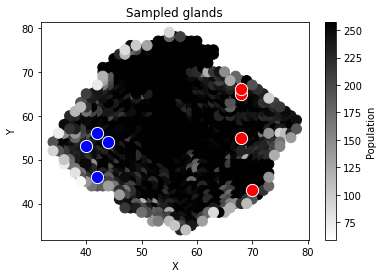

In [14]:
plot_demes(demes, left_selection, right_selection)

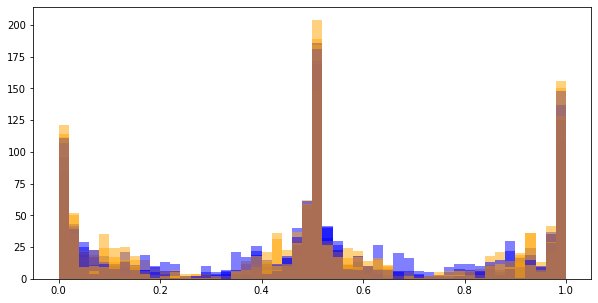

In [15]:
# Plot the methylation arrays of the selected demes on the same histogram with left glands being in a blue colour palette and right glands in orange
plt.figure(figsize=(10, 5))
for i in range(len(left_arrays)):
    plt.hist(left_arrays.iloc[i], bins=50, color='blue', alpha=0.5)
    plt.hist(right_arrays.iloc[i], bins=50, color='orange', alpha=0.5)

In [16]:
left_arrays = left_arrays.reset_index(drop=True)
right_arrays = right_arrays.reset_index(drop=True)
all_samples = pd.concat([left_arrays, right_arrays], axis=0)

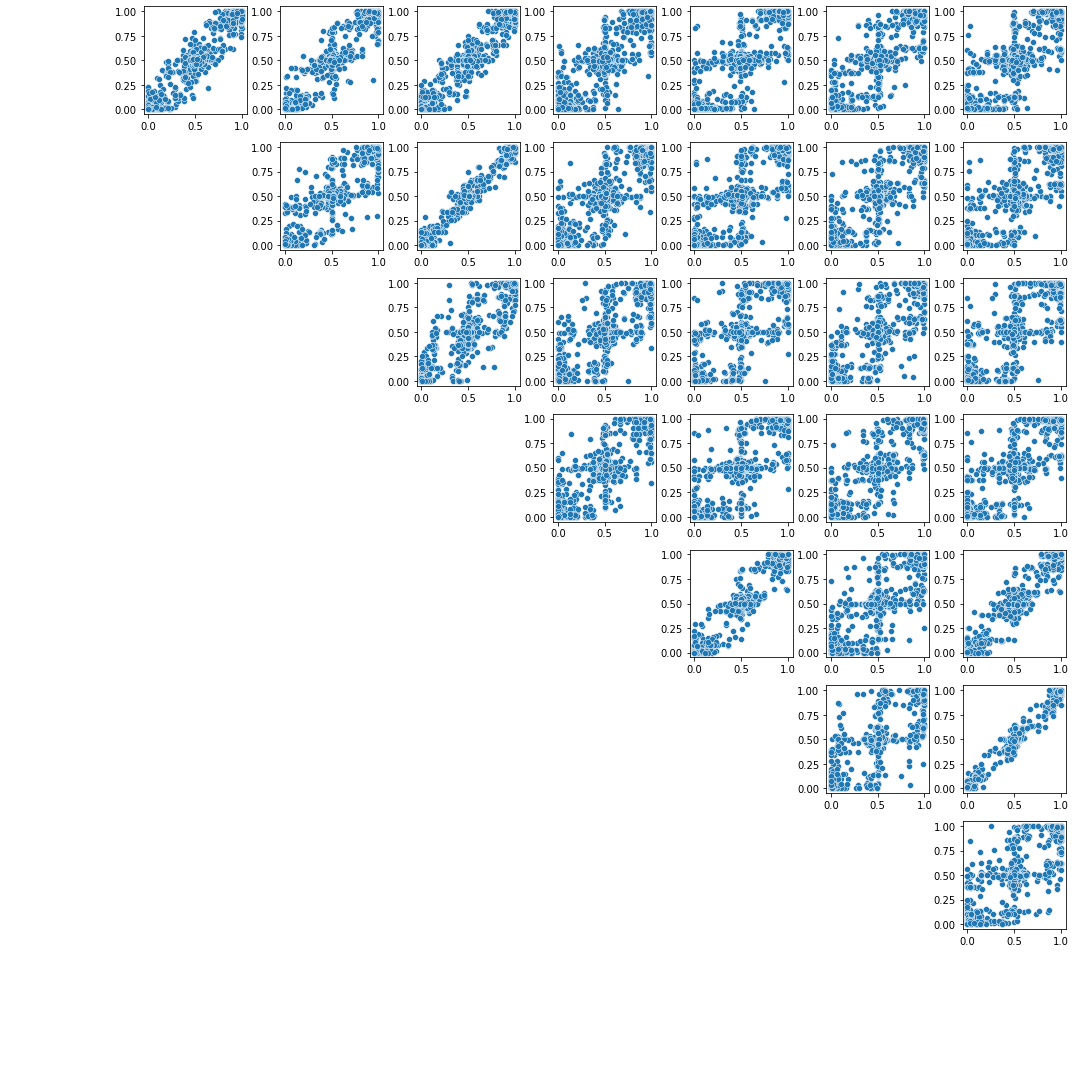

In [17]:
# Correlation plots for each two sampled demes

num_samples = 8
fig, axes = plt.subplots(num_samples, num_samples, figsize=(15, 15))

for i in range(num_samples):
    for j in range(num_samples):
        if j > i:  # plot above the diagonal
            sns.scatterplot(data=all_samples, x=all_samples.iloc[i], y=all_samples.iloc[j], ax=axes[i, j])
        else:
            axes[i, j].set_axis_off()  # Turn off axes for other plots

plt.tight_layout()
plt.show()

In [18]:
def methylation_state(value):
    if value <= 0.35:
        return 0  # homogeneously unmethylated
    elif value <= 0.65:
        return 0.5  # heterogeneously methylated
    else:
        return 1  # homogeneously methylated

In [19]:
def compute_array_distance(array1, array2, fcpgs):
    # Determine methylation states for each site in both arrays
    states1 = [methylation_state(val) for val in array1]
    states2 = [methylation_state(val) for val in array2]
    
    # Compute the Manhattan distance for each site
    distances = [abs(s1 - s2) for s1, s2 in zip(states1, states2)]
    
    # Return the average distance over all sites
    return sum(distances) / fcpgs

In [20]:
def compute_distance_matrix(all_samples, fcpgs):
    # Number of samples
    n = len(all_samples)
    
    # Initialize an empty matrix
    matrix = np.zeros((n, n))
    
    # Compute the distances
    for i in range(n):
        for j in range(n):
            if i != j:
                matrix[i, j] = compute_array_distance(all_samples.iloc[i], all_samples.iloc[j], fcpgs)
    
    return matrix

In [21]:
def plot_heatmap(matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Flip Distance'})
    plt.title('Distance Matrix Heatmap')
    plt.xlabel('Deme Index')
    plt.ylabel('Deme Index')
    plt.show()

In [22]:
distances = compute_distance_matrix(all_samples, 200)

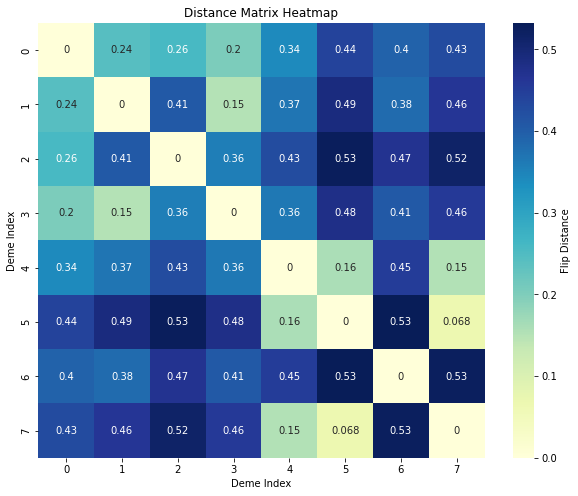

In [23]:
plot_heatmap(distances)

In [24]:
def plot_dendrogram(matrix):
    # Perform hierarchical clustering
    linked = linkage(matrix, 'average')

    # Plot the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(linked, orientation='top', labels=range(1, matrix.shape[0] + 1), distance_sort='descending', show_leaf_counts=True)
    plt.title('Dendrogram of Deme Relationships')
    plt.xlabel('Deme Index')
    plt.ylabel('Distance')
    plt.show()

/var/folders/w2/kjkvndgn0814nht_y6zf3f0m0000gn/T/ipykernel_12165/1574293558.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(matrix, 'average')


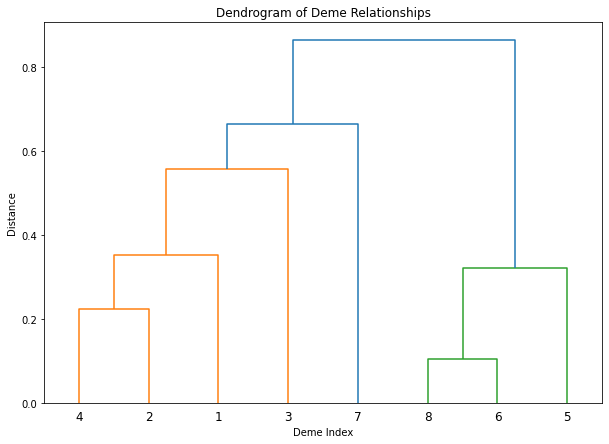

In [25]:
plot_dendrogram(distances)

meeting with Darryl:
- Edge vs budging also!!
- Run two filled initial glands with related but different arrays
- Can test early mixing with benign adenomas

meeting with Calum:
- Add noise to final state arrays.
- Shuffle glands from the same side and swap sides when doing ABC to avoid discarding potentially useful runs. Saves on compute as well. Balance assignment problem. Hungarian method.
- Doug Winton's lab paper on crypt fission

- Allow more than 1 switch per division
- Multiply Poisson by the number of sites. Actually, compare Poisson vs exp vs binomial
- desynchronisation rate
- 

Side note: Check the blood cancer example run against Calum's thesis peak position prediction